In [ ]:
# importing generic libraries
import os
import glob
import time
import random
import shutil

# Data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#copied the folders locally
!mkdir -p /content/local_images_part_1
!cp /content/gdrive/MyDrive/APS360/projectt/APS360_SkinCancer_Dataset/HAM10000_images_part_1/*.jpg /content/local_images_part_1/

!mkdir -p /content/local_images_part_2
!cp /content/gdrive/MyDrive/APS360/projectt/APS360_SkinCancer_Dataset/HAM10000_images_part_2/*.jpg /content/local_images_part_2/


In [ ]:
base_gdrive_path = '/content/gdrive/MyDrive/APS360/projectt/APS360_SkinCancer_Dataset'
metadata_path = os.path.join(base_gdrive_path, 'HAM10000_metadata.csv')

# Paths for image data locally
part1_path = '/content/local_images_part_1'
part2_path = '/content/local_images_part_2'


Total images found: 9524

Metadata preview:
           filename label
0  ISIC_0027419.jpg   bkl
1  ISIC_0025030.jpg   bkl
2  ISIC_0026769.jpg   bkl
3  ISIC_0025661.jpg   bkl
4  ISIC_0031633.jpg   bkl

Class Distribution:


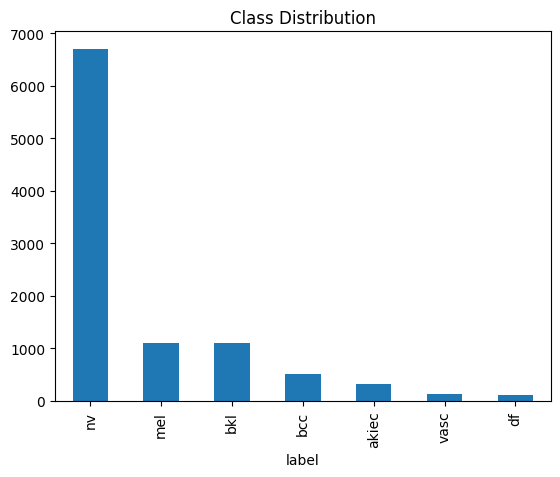

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Set the desired size for all images
TARGET_SHAPE = (260, 260)

# Grab all image file paths from the provided directories
def collect_image_paths(*directories):
    all_paths = []
    for directory in directories:
        image_files = glob.glob(os.path.join(directory, '*.jpg'))
        all_paths.extend(image_files)
    return all_paths

# Open and normalize an image given its file path
def load_and_prepare_image(img_path, shape=TARGET_SHAPE):
    try:
        with Image.open(img_path) as image:
            image = image.convert('RGB').resize(shape)
            return np.asarray(image, dtype=np.float32) / 255.0
    except Exception as e:
        print(f"Warning: Could not preprocess image {img_path}: {e}")
        # If there's an issue, return a blank image
        return np.full((*shape, 3), 0.0, dtype=np.float32)

# Read and clean up the metadata file for use
def prepare_metadata(metadata_file):
    raw_df = pd.read_csv(metadata_file)
    # Add ".jpg" extension to match filenames
    raw_df['filename'] = raw_df['image_id'].map(lambda name: f"{name}.jpg")
    # Rename label column for clarity
    raw_df.rename(columns={'dx': 'label'}, inplace=True)
    return raw_df

# Visualize how many samples exist for each class
def plot_label_distribution(dataframe, label_col='label'):
    class_counts = dataframe[label_col].value_counts()
    class_counts.plot(kind='bar', title='Class Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Load and prepare the metadata
df_metadata = prepare_metadata(metadata_path)

# Show a quick look at the filenames and labels
print("\nMetadata preview:")
print(df_metadata[['filename', 'label']].head())

# Gather all image file paths across both parts
image_files = collect_image_paths(part1_path, part2_path)
print(f"Total images found: {len(image_files)}")

# Display a bar chart of how many images per class
print("\nClass Distribution:")
plot_label_distribution(df_metadata)

In [ ]:
# Match image files to their full paths using a lookup table
path_lookup = dict()
for full_path in all_image_paths:
    file_id = os.path.basename(full_path)
    path_lookup[file_id] = full_path

# Only keep metadata entries with matching image files
valid_rows = df[df['filename'].isin(path_lookup)].copy()

# Map full paths to a new column in the filtered metadata
valid_rows['filepath'] = valid_rows['filename'].apply(lambda name: path_lookup[name])

# Shuffle the dataset before splitting
shuffled = valid_rows.sample(frac=1.0, random_state=36).reset_index(drop=True)

# Determine how many entries should go into each subset
count = len(shuffled)
train_end = int(0.7 * count)
val_end = train_end + int(0.15 * count)

# Split the DataFrame into train, val, and test slices
train_df = shuffled.iloc[:train_end]
val_df = shuffled.iloc[train_end:val_end]
test_df = shuffled.iloc[val_end:]

# Print counts for each subset
print(f"\nTrain samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")



Train samples: 6629
Val samples: 1420
Test samples: 1421


In [ ]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms

# Custom dataset for skin lesion classification
class SkinImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.entries = dataframe.reset_index(drop=True)
        self.transform = transform

        # Build class index mappings from unique labels
        class_labels = sorted(df['label'].unique())
        self.class_to_index = {label: i for i, label in enumerate(class_labels)}
        self.index_to_class = {i: label for label, i in self.class_to_index.items()}
        self.total_classes = len(self.class_to_index)

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        # Retrieve image path and label
        image_file = self.entries.loc[idx, 'filepath']
        label_str = self.entries.loc[idx, 'label']
        label_idx = self.class_to_index[label_str]

        # Preprocess image into tensor format
        image_arr = transform_image(image_file)
        image_tensor = torch.tensor(image_arr).permute(2, 0, 1).float()

        # Apply transformations if any
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label_idx

# Predefined ImageNet normalization values
MEAN_RGB = [0.485, 0.456, 0.406]
STD_RGB = [0.229, 0.224, 0.225]

# Data augmentation for training to improve model robustness
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.RandomRotation(15),
    transforms.Normalize(mean=MEAN_RGB, std=STD_RGB)
])

# Simpler normalization for validation/testing
eval_transforms = transforms.Compose([
    transforms.Normalize(mean=MEAN_RGB, std=STD_RGB)
])

# Parameters for data loading
BATCH_SIZE = 32
NUM_WORKERS = 2

# Create dataset instances
train_data = SkinImageDataset(train_df, transform=train_transforms)
val_data = SkinImageDataset(val_df, transform=eval_transforms)
test_data = SkinImageDataset(test_df, transform=eval_transforms)

# Retrieve class metadata
num_classes = train_data.total_classes
class_names = [train_data.index_to_class[i] for i in range(num_classes)]

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 7
Class names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Number of training batches: 208
Number of validation batches: 45
Number of test batches: 45


In [ ]:
import torch.nn as nn
from torchvision import models

# Custom function to prepare a classification model using EfficientNet-B2
def initialize_model(output_classes):
    # Load the pretrained EfficientNet-B2 model with ImageNet weights
    pretrained_net = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)

    # Get the size of the input to the final layer
    feature_count = pretrained_net.classifier[1].in_features

    # Replace the last classification layer with a custom output layer
    pretrained_net.classifier[1] = nn.Linear(feature_count, output_classes)

    # Move model to the appropriate device (CPU or GPU)
    return pretrained_net.to(device)

# Create the model instance
model = initialize_model(num_classes)

# Print summary of architecture
print("\nModel Architecture:")
print(model)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 117MB/s]



Model Architecture:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (

In [ ]:
#loss function and optimizer
criterion = nn.CrossEntropyLoss() # Standard for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_and_validate(model, loader_train, loader_val, criterion, optimizer, num_epochs=20, checkpoint_file='best_model.pth'):
    best_val_acc = 0.0
    train_losses, val_losses, val_accuracies = [], [], []

    print("\nStarting training...")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        seen = 0

        for step, (images, labels) in enumerate(loader_train):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == labels).sum().item()
            seen += labels.size(0)

        epoch_loss = total_loss / len(loader_train.dataset)
        epoch_acc = correct / seen
        train_losses.append(epoch_loss)

        model.eval()
        val_loss_accum = 0
        val_correct = 0
        val_count = 0

        with torch.no_grad():
            for val_inputs, val_labels in loader_val:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                v_loss = criterion(val_outputs, val_labels)

                val_loss_accum += v_loss.item() * val_inputs.size(0)
                predicted = torch.argmax(val_outputs, dim=1)
                val_correct += (predicted == val_labels).sum().item()
                val_count += val_labels.size(0)

        val_loss_avg = val_loss_accum / len(loader_val.dataset)
        val_acc = val_correct / val_count
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), checkpoint_file)
            print(f"  --> Saved new best model with Val Accuracy: {best_val_acc:.4f}")

    print("\nTraining complete!")
    return train_losses, val_losses, val_accuracies


def evaluate_model(model, dataloader, loss_fn, label_names, model_file='best_model.pth'):
    try:
        model.load_state_dict(torch.load(model_file))
        print(f"\nLoaded model from {model_file} for evaluation.")
    except FileNotFoundError:
        print(f"\nError: Model file not found at {model_file}. Please ensure training was successful.")
        return

    model.eval()
    loss_sum = 0
    total = 0
    hits = 0

    y_preds = []
    y_trues = []

    with torch.inference_mode():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            scores = model(inputs)
            loss = loss_fn(scores, targets)

            loss_sum += loss.item() * inputs.size(0)
            total += targets.size(0)

            _, preds = torch.max(scores, dim=1)
            hits += (preds == targets).sum().item()

            y_preds.extend(preds.cpu().numpy())
            y_trues.extend(targets.cpu().numpy())

    avg_loss = loss_sum / len(dataloader.dataset)
    acc = hits / total

    print(f"\nEvaluation Results")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_trues, y_preds, target_names=label_names, zero_division=0))

    cmatrix = confusion_matrix(y_trues, y_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


Starting training...
Epoch 1/20: Train Loss: 0.7800, Train Acc: 0.7283 | Val Loss: 0.6304, Val Acc: 0.7852
  --> Saved new best model with Val Accuracy: 0.7852
Epoch 2/20: Train Loss: 0.6145, Train Acc: 0.7814 | Val Loss: 0.4982, Val Acc: 0.8225
  --> Saved new best model with Val Accuracy: 0.8225
Epoch 3/20: Train Loss: 0.5241, Train Acc: 0.8075 | Val Loss: 0.5013, Val Acc: 0.8359
  --> Saved new best model with Val Accuracy: 0.8359
Epoch 4/20: Train Loss: 0.4745, Train Acc: 0.8286 | Val Loss: 0.4832, Val Acc: 0.8289
Epoch 5/20: Train Loss: 0.4401, Train Acc: 0.8430 | Val Loss: 0.5039, Val Acc: 0.8232
Epoch 6/20: Train Loss: 0.4178, Train Acc: 0.8464 | Val Loss: 0.4176, Val Acc: 0.8599
  --> Saved new best model with Val Accuracy: 0.8599
Epoch 7/20: Train Loss: 0.3951, Train Acc: 0.8567 | Val Loss: 0.4186, Val Acc: 0.8500
Epoch 8/20: Train Loss: 0.3492, Train Acc: 0.8751 | Val Loss: 0.4005, Val Acc: 0.8634
  --> Saved new best model with Val Accuracy: 0.8634
Epoch 9/20: Train Loss: 0

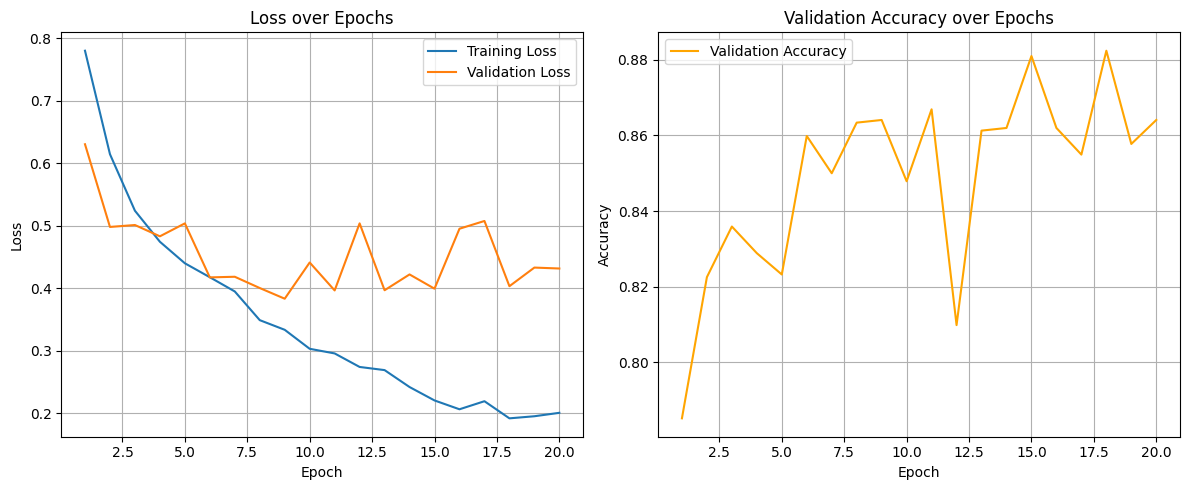


Loaded model from best_model.pth for evaluation.

--- Evaluation Results ---
Loss: 0.4504
Accuracy: 0.8564

Classification Report:
              precision    recall  f1-score   support

       akiec       0.68      0.76      0.72        50
         bcc       0.66      0.86      0.75        65
         bkl       0.74      0.72      0.73       162
          df       0.86      0.63      0.73        19
         mel       0.69      0.44      0.54       142
          nv       0.92      0.95      0.93       965
        vasc       0.78      0.78      0.78        18

    accuracy                           0.86      1421
   macro avg       0.76      0.73      0.74      1421
weighted avg       0.85      0.86      0.85      1421



NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
def plot_training_summary(loss_train, loss_val, acc_val, n_epochs):
    timeline = range(1, n_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot training vs validation loss
    plt.subplot(1, 2, 1)
    plt.plot(timeline, loss_train, label='Training Loss')
    plt.plot(timeline, loss_val, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(timeline, acc_val, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # Set the total number of epochs for training
    NUM_EPOCHS = 20

    # Train the model and record performance metrics
    loss_log_train, loss_log_val, accuracy_log_val = train_and_validate(
        model=model,
        loader_train=loader_train,
        loader_val=loader_val,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS
    )

    # Generate visual plots for training curves
    plot_training_summary(
        loss_train=loss_log_train,
        loss_val=loss_log_val,
        acc_val=accuracy_log_val,
        n_epochs=NUM_EPOCHS
    )

    # Run final evaluation using the best saved model
    evaluate_model(model, loader_test, criterion, class_names)



--- Generating Additional Analysis Results ---

Weighted Average F1 Score: 0.8504

Full Classification Report (for Weighted F1 context):
              precision    recall  f1-score   support

       akiec       0.68      0.76      0.72        50
         bcc       0.66      0.86      0.75        65
         bkl       0.74      0.72      0.73       162
          df       0.86      0.63      0.73        19
         mel       0.69      0.44      0.54       142
          nv       0.92      0.95      0.93       965
        vasc       0.78      0.78      0.78        18

    accuracy                           0.86      1421
   macro avg       0.76      0.73      0.74      1421
weighted avg       0.85      0.86      0.85      1421



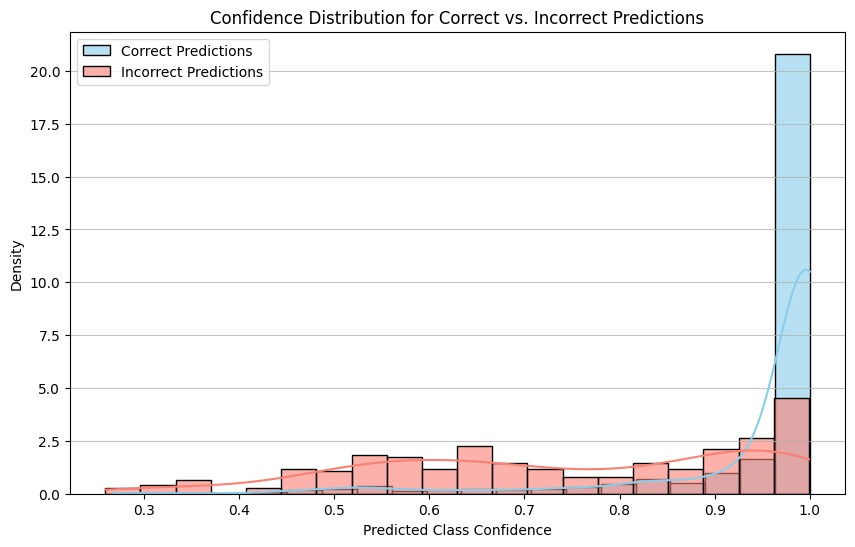


Additional analysis complete.


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score


def extract_labels_and_confidences(net, dataloader, device_ref):
    net.eval()
    targets = []
    guesses = []
    confidences = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device_ref), batch_y.to(device_ref)
            outputs = net(batch_x)

            soft_scores = F.softmax(outputs, dim=1)
            predicted_classes = torch.argmax(outputs, dim=1)

            targets.extend(batch_y.cpu().numpy())
            guesses.extend(predicted_classes.cpu().numpy())
            confidences.extend(soft_scores.cpu().numpy())

    return np.array(targets), np.array(guesses), np.array(confidences)


def report_weighted_f1(actuals, preds, label_names):
    f1_weighted = f1_score(actuals, preds, average='weighted', zero_division=0)
    print(f"\nWeighted Average F1 Score: {f1_weighted:.4f}")

    print("\nFull Classification Report (for Weighted F1 context):")
    print(classification_report(actuals, preds, target_names=label_names, zero_division=0))


def show_confidence_distributions(actuals, preds, softmax_matrix, label_names):
    # Grab the softmax score for the predicted class for each sample
    confidence_vals = np.array([
        softmax_matrix[i, preds[i]] for i in range(len(preds))
    ])

    # Identify correct vs incorrect predictions
    is_correct = (preds == actuals)
    conf_right = confidence_vals[is_correct]
    conf_wrong = confidence_vals[~is_correct]

    plt.figure(figsize=(10, 6))
    sns.histplot(conf_right, color='mediumseagreen', label='Correct Predictions',
                 bins=20, kde=True, stat='density', alpha=0.6)
    sns.histplot(conf_wrong, color='tomato', label='Incorrect Predictions',
                 bins=20, kde=True, stat='density', alpha=0.6)

    plt.title('Distribution of Model Confidence for Correct and Incorrect Predictions')
    plt.xlabel('Confidence Score for Predicted Class')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.7)
    plt.show()


if __name__ == '__main__':
    print("\n--- Starting Supplementary Evaluation ---")
    true_y, pred_y, class_confidence = extract_labels_and_confidences(model, loader_test, device)
    report_weighted_f1(true_y, pred_y, class_names)
    show_confidence_distributions(true_y, pred_y, class_confidence, class_names)
    print("\nSupplementary evaluation completed successfully.")
